#**II. METRIC**


##ROLL RATE MATRIX

In [ ]:
df_repayment_6_12 = df[df['MONTH_ON_BOOK'].isin([6, 12])]
df_repayment_6_12_tf = df_repayment_6_12.groupby('CONTRACT_NO').agg({'DPD_BUCKET':['first', 'last']})
df_repayment_6_12_tf.columns = ['_'.join(x) for x in df_repayment_6_12_tf.columns]
df_repayment_6_12_tf = df_repayment_6_12_tf.reset_index()
df_repayment_6_12_tf

,CONTRACT_NO,DPD_BUCKET_first,DPD_BUCKET_last
0,340732,B0,B0
1,341505,B0,B3
2,341586,B0,B0
3,342421,B3,B10
4,342823,B0,B5
...,...,...,...
101038,856744,B7,B14
101039,856747,B4,B10
101040,856750,B7,B14
101041,856760,B5,B14


In [ ]:
rollrate = pd.pivot_table(df_repayment_6_12_tf, values='CONTRACT_NO', index=['DPD_BUCKET_first'],
                       columns=['DPD_BUCKET_last'], aggfunc="count", fill_value=0, margins = True)
rollrate2 = rollrate.div(rollrate.iloc[:,-1], axis=0 )

sorted_columns = sorted(rollrate2.columns, key=lambda x: (int(x[1:]) if x != 'All' else float('inf')))

# Reorder the columns in the DataFrame
df_sorted = rollrate2[sorted_columns]

df_sorted.to_csv('rollrate.csv')
df_sorted


DPD_BUCKET_last,B0,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B14,All
DPD_BUCKET_first,,,,,,,,,,,,,
B0,0.719107,0.004636,0.055210,0.045366,0.044542,0.044179,0.042894,0.040967,0.003100,0.000000,0.000000,0.000000,1.0
B1,0.076179,0.043531,0.065296,0.043531,0.061669,0.081016,0.090689,0.118501,0.419589,0.000000,0.000000,0.000000,1.0
B2,0.034035,0.003333,0.055789,0.038421,0.047018,0.050877,0.079298,0.107544,0.545789,0.037895,0.000000,0.000000,1.0
B3,0.009141,0.000548,0.008592,0.010603,0.017550,0.021024,0.034004,0.036563,0.065082,0.735466,0.061426,0.000000,1.0
B4,0.002957,0.000000,0.000821,0.001807,0.006406,0.008541,0.013305,0.010512,0.024310,0.039258,0.833771,0.058311,1.0
B5,0.001317,0.000000,0.000219,0.000658,0.000439,0.002414,0.006585,0.003292,0.003292,0.010097,0.025241,0.946444,1.0
B6,0.000234,0.000000,0.000234,0.000000,0.000234,0.000468,0.001403,0.000468,0.000935,0.000468,0.002104,0.993453,1.0
B7,0.000412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000412,0.000000,0.000000,0.999177,1.0
B8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0


##FLOW RATE MATRIX

In [ ]:
result = []

for row in df_sorted.index[:-1]:
    stay = df_sorted.loc[row, row]
    cure = df_sorted.loc[row, :row].iloc[:-1].sum() if row != "B0" else np.nan
    roll = df_sorted.loc[row, row:].iloc[1:-1].sum()
    if not np.isnan(cure):
        roll = 1 - stay - cure
    result.append([row, cure, stay, roll])

result_df = pd.DataFrame(result, columns=["DPD_Bucket", "Cure", "Stay", "Roll"])
result_df[["Cure", "Stay", "Roll"]] = result_df[["Cure", "Stay", "Roll"]].multiply(100).round(12)
result_df["Cure"] = result_df["Cure"].apply(lambda x: f"{x:.2f}%" if x != "" else "")
result_df["Stay"] = result_df["Stay"].apply(lambda x: f"{x:.2f}%")
result_df["Roll"] = result_df["Roll"].apply(lambda x: f"{x:.2f}%")
result_df["Cure"] = result_df["Cure"].replace({"nan%": " "})

print(result_df.to_string(index=False))


DPD_Bucket  Cure   Stay    Roll
        B0       71.91%  28.09%
        B1 7.62%  4.35%  88.03%
        B2 3.74%  5.58%  90.68%
        B3 1.83%  1.06%  97.11%
        B4 0.56%  0.64%  98.80%
        B5 0.26%  0.24%  99.50%
        B6 0.12%  0.14%  99.74%
        B7 0.04%  0.00%  99.96%
        B8 0.00%  0.00% 100.00%


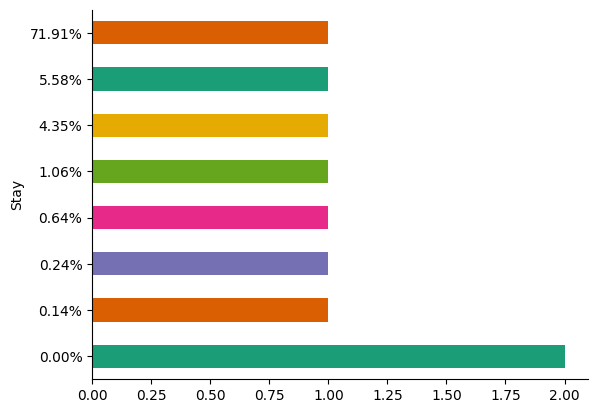

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
result_df.groupby('Stay').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

##TRANSACTION MATRIX


In [ ]:

# Prepare the migration data
# Get the bucket status by month
data_sorted = df.sort_values(['CONTRACT_NO', 'MONTH_ON_BOOK'])
data_grouped = data_sorted.groupby('CONTRACT_NO')

# Get bucket at current and next time
data_sorted['Next_Bucket'] = data_grouped['DPD_BUCKET'].shift(-1)

# Create transaction matrix
transaction_matrix = pd.crosstab(data_sorted['DPD_BUCKET'], data_sorted['Next_Bucket'], normalize='index')

sorted_columns = sorted(transaction_matrix.columns, key=lambda x: int(x[1:]))
transaction_matrix_final = transaction_matrix[sorted_columns]
transaction_matrix_final

sorted_index = sorted(transaction_matrix.index, key=lambda x: int(x[1:]))
transaction_matrix_final_sorted = transaction_matrix_final.reindex(sorted_index)

# Display the final sorted DataFrame
transaction_matrix_final_sorted.round(3).to_csv('transaction.csv')
transaction_matrix_final_sorted



Next_Bucket,B0,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B14
DPD_BUCKET,,,,,,,,,,,,
B0,0.942013,0.005654,0.051670,0.000662,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B1,0.069058,0.242778,0.121725,0.566438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B2,0.042628,0.012915,0.222677,0.714000,0.007781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B3,0.009201,0.002598,0.020349,0.080748,0.878423,0.008681,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
B4,0.003654,0.000270,0.002280,0.004487,0.079964,0.892867,0.016478,0.000000,0.000000,0.000000,0.000000,0.000000
B5,0.001287,0.000086,0.000601,0.000343,0.003947,0.051677,0.922641,0.019418,0.000000,0.000000,0.000000,0.000000
B6,0.000831,0.000000,0.000299,0.000133,0.000133,0.001496,0.034896,0.951577,0.010635,0.000000,0.000000,0.000000
B7,0.000195,0.000000,0.000078,0.000039,0.000000,0.000117,0.000272,0.012411,0.978525,0.008364,0.000000,0.000000
B8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002626,0.979131,0.018242,0.000000


##VINTAGE MATRIX

In [ ]:
# Chuyển đổi SYS_RUN_DATE sang kiểu datetime
df_repayment_vintage = df.copy()
df_repayment_vintage['SYS_RUN_DATE'] = pd.to_datetime(df_repayment_vintage['SYS_RUN_DATE'], errors='coerce')

# Tính toán ORIGIN_QUARTER (thay vì ORIGIN_MONTH)
# Sử dụng .dt.to_period('Q') để chuyển thành quý (quarter)
df_repayment_vintage['ORIGIN_QUARTER'] = (df_repayment_vintage['SYS_RUN_DATE'] - pd.to_timedelta(df_repayment_vintage['MONTH_ON_BOOK'] * 30, unit='D')).dt.to_period('Q')

# Step 1: Create flags for 30 DPD and 90 DPD
df_repayment_vintage['IS_30_DPD'] = df_repayment_vintage['OVER_DUE_DAYS_CLIENT'] >= 30
df_repayment_vintage['IS_90_DPD'] = df_repayment_vintage['OVER_DUE_DAYS_CLIENT'] >= 90

# Step 2: Group data by ORIGIN_QUARTER and MONTH_ON_BOOK, and calculate relevant metrics
dpd_matrix = (
    df_repayment_vintage.groupby(['ORIGIN_QUARTER', 'MONTH_ON_BOOK'])
    .agg(
        Total_Customers=('CONTRACT_NO', 'count'),
        Customers_30_DPD=('IS_30_DPD', 'sum'),
        Customers_90_DPD=('IS_90_DPD', 'sum')
    )
    .reset_index()
)

# Step 3: Calculate 30 DPD and 90 DPD rates
dpd_matrix['30_DPD_Rate'] = (dpd_matrix['Customers_30_DPD'] / dpd_matrix['Total_Customers']) * 100
dpd_matrix['90_DPD_Rate'] = (dpd_matrix['Customers_90_DPD'] / dpd_matrix['Total_Customers']) * 100

# Step 4: Pivot the data to create separate matrices for 30 DPD and 90 DPD rates
dpd_30_pivot = dpd_matrix.pivot(
    index='ORIGIN_QUARTER',  # Change to ORIGIN_QUARTER
    columns='MONTH_ON_BOOK',
    values='30_DPD_Rate'
).fillna(0)

dpd_90_pivot = dpd_matrix.pivot(
    index='ORIGIN_QUARTER',  # Change to ORIGIN_QUARTER
    columns='MONTH_ON_BOOK',
    values='90_DPD_Rate'
).fillna(0)
dpd_30_pivot = dpd_30_pivot[dpd_30_pivot.index != '2022Q1']
dpd_90_pivot = dpd_90_pivot[dpd_90_pivot.index != '2022Q1']
# Display 30 DPD pivot table for reference
dpd_30_pivot.to_excel('dpd_30_pivot.xlsx')
dpd_90_pivot.to_excel('dpd_90_pivot.xlsx')
dpd_30_pivot.round(2)


MONTH_ON_BOOK,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
ORIGIN_QUARTER,,,,,,,,,,,,,
2022Q2,0.0,0.03,1.48,4.34,8.19,14.62,20.14,25.30,30.50,35.29,39.36,43.16,46.68
2022Q3,0.0,0.04,3.65,9.02,14.20,20.67,26.21,30.80,34.97,38.38,41.42,44.27,46.95
2022Q4,0.0,0.08,2.76,9.29,13.86,19.46,24.06,28.05,31.54,34.64,37.66,40.26,42.82
2023Q1,0.0,0.04,3.03,6.22,10.61,15.32,19.30,22.62,26.13,29.18,31.93,34.43,36.70


In [ ]:
dpd_90_pivot.round(2)

MONTH_ON_BOOK,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
ORIGIN_QUARTER,,,,,,,,,,,,,
2022Q2,0.0,0.0,0.0,0.09,1.41,3.71,7.61,13.80,18.96,24.08,29.05,33.90,37.98
2022Q3,0.0,0.0,0.0,0.03,3.59,8.56,13.47,19.66,25.04,29.65,33.71,37.23,40.35
2022Q4,0.0,0.0,0.0,0.06,3.14,8.70,13.25,18.93,23.32,27.17,30.37,33.32,36.28
2023Q1,0.0,0.0,0.0,0.02,1.58,6.12,10.44,14.85,18.45,21.50,24.93,28.00,30.77


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313559 entries, 0 to 1313558
Data columns (total 58 columns):
 #   Column                         Non-Null Count    Dtype         
---  ------                         --------------    -----         
 0   CONTRACT_NO                    1313559 non-null  int64         
 1   SYS_RUN_DATE                   1313559 non-null  datetime64[ns]
 2   TOTAL_EMI_AMOUNT               1313559 non-null  float64       
 3   DUE_DATE_OF_MON                1313559 non-null  datetime64[ns]
 4   PARTNER_CODE                   1313559 non-null  int64         
 5   OUTSTANDING                    1313559 non-null  float64       
 6   PRI_PAST_DUE                   1313559 non-null  float64       
 7   INT_PAST_DUE                   1313559 non-null  float64       
 8   OD_PAST_DUE                    1313559 non-null  float64       
 9   OVER_DUE_DAYS_LD               1313559 non-null  float64       
 10  OVER_DUE_DAYS_CLIENT           1313559 non-null  float

##Monthly Roll Rate

###Monthly Roll Rate for B0 Bucket

In [ ]:

# Ensure SYS_RUN_DATE is treated as a datetime object
df['SYS_RUN_DATE'] = pd.to_datetime(df['SYS_RUN_DATE'])

# Sort data by contract number and system run date
df = df.sort_values(by=['CONTRACT_NO', 'SYS_RUN_DATE'])

# Shift the bucket column to calculate transitions month over month
df['Previous_Bucket'] = df.groupby('CONTRACT_NO')['DPD_BUCKET'].shift(1)

# Filter rows where the previous bucket was B0
b0_transitions_updated = df[df['Previous_Bucket'] == "B0"]

# Recalculate the monthly roll rates using the updated classification
roll_rate_data_updated = (
    b0_transitions_updated.groupby(b0_transitions_updated['SYS_RUN_DATE'].dt.to_period('M'))
    .apply(lambda x: (x['DPD_BUCKET'] != "B0").mean() * 100)
    .reset_index(name='Roll Rate (%)')
)

# Rename the date column for clarity
roll_rate_data_updated['Month'] = roll_rate_data_updated['SYS_RUN_DATE'].astype(str)
roll_rate_data_updated = roll_rate_data_updated[['Month', 'Roll Rate (%)']]

# Display the updated roll rate data to the user
print("Updated Monthly Roll Rate for B0 Bucket:")
print(roll_rate_data_updated)

Updated Monthly Roll Rate for B0 Bucket:
      Month  Roll Rate (%)
0   2022-04       3.772291
1   2022-05       3.956883
2   2022-06       3.882883
3   2022-07       3.403650
4   2022-08       4.351583
5   2022-09       6.147504
6   2022-10       6.213472
7   2022-11       6.515329
8   2022-12       7.053527
9   2023-01       8.418723
10  2023-02       5.529715
11  2023-03       5.843274
12  2023-04       6.956392
13  2023-05       5.725826
14  2023-06       5.489200
15  2023-07       5.408244
16  2023-08       4.979410
17  2023-09       5.385173
18  2023-10       4.613695
19  2023-11       4.452118
20  2023-12       4.158853
21  2024-01       3.999579
22  2024-02       4.790895


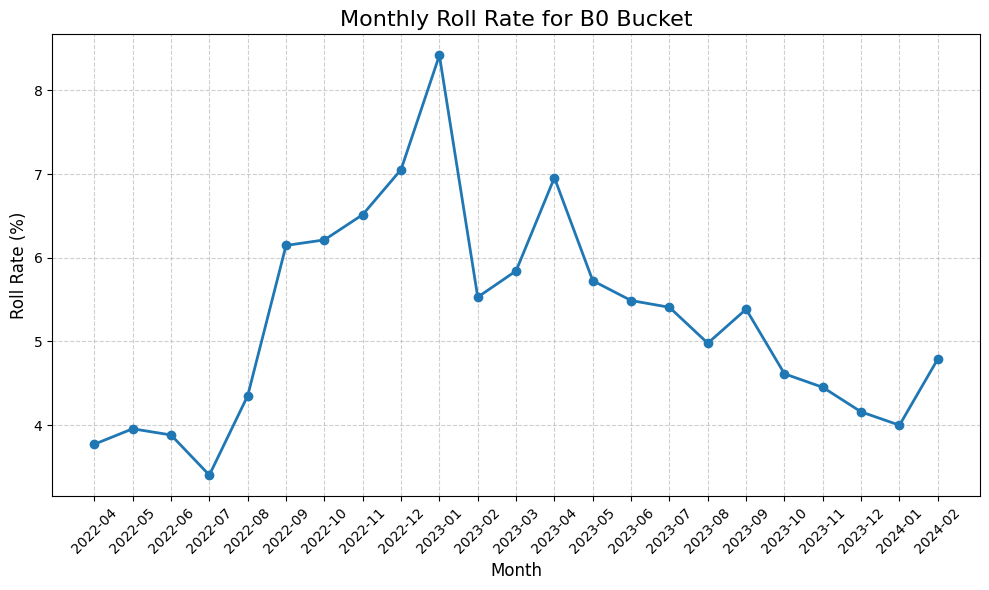

In [ ]:
# Create a line plot for the roll rate data
plt.figure(figsize=(10, 6))
plt.plot(roll_rate_data_updated['Month'], roll_rate_data_updated['Roll Rate (%)'], marker='o', linestyle='-', linewidth=2)

# Add labels, title, and grid
plt.title('Monthly Roll Rate for B0 Bucket', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Roll Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

###Monthly Roll Rates: B0 to All Higher Buckets (B1 to B14)

In [ ]:
# Calculate roll rates from B0 to each higher bucket (B1 to B14)
def calculate_bucket_roll_rate(group):
    total_b0 = len(group)
    roll_rates = {}
    for bucket in group['DPD_BUCKET'].unique():
        if bucket != "B0":  # Only consider transitions to higher buckets
            roll_rates[bucket] = (group['DPD_BUCKET'] == bucket).sum() / total_b0 * 100
    return roll_rates

# Group data by month and calculate roll rates for each bucket
bucket_roll_rates = (
    b0_transitions_updated.groupby(b0_transitions_updated['SYS_RUN_DATE'].dt.to_period('M'))
    .apply(calculate_bucket_roll_rate)
)

# Transform the roll rates into a DataFrame for easier analysis
bucket_roll_rates_df = pd.DataFrame(bucket_roll_rates.tolist(), index=bucket_roll_rates.index).fillna(0)
bucket_roll_rates_df.index = bucket_roll_rates_df.index.astype(str)
bucket_roll_rates_df.reset_index(inplace=True)
bucket_roll_rates_df.rename(columns={'index': 'Month'}, inplace=True)

# Display the roll rate data
print(bucket_roll_rates_df)

   SYS_RUN_DATE        B2        B1        B3        B4
0       2022-04  3.374486  0.397805  0.000000  0.000000
1       2022-05  3.575254  0.381628  0.000000  0.000000
2       2022-06  3.450450  0.432432  0.000000  0.000000
3       2022-07  3.018528  0.204705  0.180418  0.000000
4       2022-08  3.969670  0.228591  0.153323  0.000000
5       2022-09  5.628189  0.519315  0.000000  0.000000
6       2022-10  5.682884  0.347077  0.181517  0.001995
7       2022-11  5.925610  0.589719  0.000000  0.000000
8       2022-12  6.537644  0.318909  0.196973  0.000000
9       2023-01  6.090857  2.327865  0.000000  0.000000
10      2023-02  3.977416  1.552299  0.000000  0.000000
11      2023-03  5.478826  0.201724  0.162724  0.000000
12      2023-04  6.447133  0.509259  0.000000  0.000000
13      2023-05  5.552727  0.173098  0.000000  0.000000
14      2023-06  5.098763  0.390437  0.000000  0.000000
15      2023-07  5.093200  0.170648  0.144395  0.000000
16      2023-08  4.666145  0.138949  0.174317  0

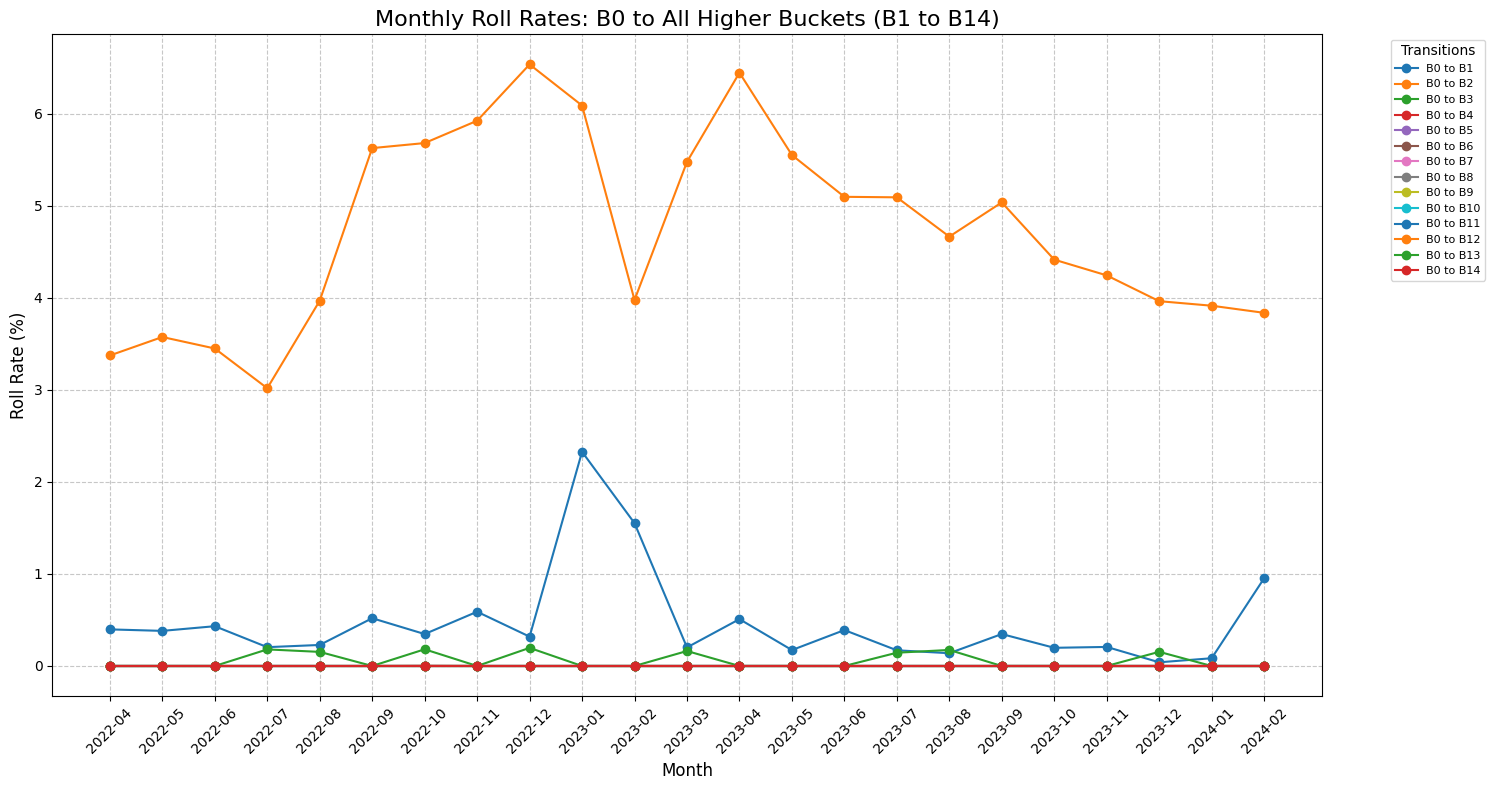

In [ ]:
# Get all bucket columns explicitly from B1 to B14
buckets_to_plot = [f"B{i}" for i in range(1, 15)]

# Ensure all selected buckets exist in the data, fill missing ones with zero
for bucket in buckets_to_plot:
    if bucket not in bucket_roll_rates_df.columns:
        bucket_roll_rates_df[bucket] = 0

# Plot transitions from B0 to B1 through B14
plt.figure(figsize=(15, 8))

# Access the 'SYS_RUN_DATE' column instead of 'Month' for the x-axis
for bucket in buckets_to_plot:
    plt.plot(bucket_roll_rates_df['SYS_RUN_DATE'], bucket_roll_rates_df[bucket], marker='o', label=f'B0 to {bucket}')

# Add plot details
plt.title('Monthly Roll Rates: B0 to All Higher Buckets (B1 to B14)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Roll Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Transitions', fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()